# MACD - Moving Average Convergence Divergence

## 0. Objectives

In this notebook, we will be using real stock data (GOOGLE, ticker : GOOG), but it works with any available ticker) and implement MACD indicators to understand their mecanism and how they can be useful for algorithmic trading.
We will be double-checking our implementations with Ta-Lib, a widely used open-source trading software to perform technical analysis of financial market data.

For simplicity here, we decided to use stock closing prices, however as always, these analysis can be done using opening prices or intra-day trading data as well, provided one has access to them.

## 1. Definitions

**Moving Average Convergence Divergence (MACD)** is a **momentum** and **trend-following** technical indicator (or oscillator). It’s composed of 3 times series:
1. **MACD line** which is calculated by subtracting the 26-day exponential moving average (Slow EMA) from the 12-day EMA (Fast EMA) of an asset’s price (often close).
2. **MACD Signal** line which is calculated as the 9-day exponential moving average (EMA) of the MACD line.
3. **MACD Histogram** (Also called divergence), which is the difference between the MACD line and its Signal line.

**Formulas**
- $MACD_{Line} = 12_{day} EMA - 26_{day} EMA$

  Where the 12-day and 26-day EMA are exponential moving averages
- $Signal Line = 9_{day} EMA_{of the MACD Line}$

  Where the 9-day EMA is calculated in the same manner as the EMA in the MACD line formula
- $MACD Histogram = MACD_{Line} - SignalLine$


**Momentum Indicators:**

- **What ?** They measure the speed or velocity of price changes in a stock, currency, or another financial asset.
- **Purpose** They help traders identify how strong a price trend is. A high momentum means a strong trend and vice versa.
- **How They Work** Momentum indicators compare current prices to previous prices. If the current price is significantly higher than past prices, the momentum is considered high.


**Trend Following Indicators:**

- **What ?** These indicators help traders identify and follow the direction of market trends.
- **Purpose** The main idea is to detect and ride the trend, buying when trends are upward and selling when trends are downward.
- **How They Work** They smooth out price data over time, making it easier to identify a trend.

**Exponential moving average formula (EMA))**
<p align="center">
$EMA = (P*alpha) + (Previous_{EMA}*(1-alpha))$

where 

- P = current Price
- alpha = smoothing factor = $\frac{2}{1+N}$ 
- N = Number of times periods
</p>


**Why 12 and 26 ?**

They represent Short and Intermediate Terms:

12-Day EMA is considered a short-term moving average. It reacts more quickly to recent price changes, making it sensitive to short-term movements.

26-Day EMA represents a more intermediate term. It's slower and less sensitive to daily price fluctuations, providing a broader view of the trend.

**Buy signal**

A buy signal is generated when the MACD line **crosses above** the signal line (bullish signal), while a sell signal is generated when the MACD line **crosses below** the signal line (bearish signal). The MACD histogram (divergence) can reveal **reversal trends**.

More information at <a href="https://fr.wikipedia.org/wiki/MACD">MACD Wikipedia article</a>

## 2. Setting up data

Load data set using Google stock from 1st of January 2022 until now (25th of November 2023, at the time of writing)

In [41]:
import talib
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [42]:
def download_stock_data(ticker,timestamp_start,timestamp_end):
    url="https://query1.finance.yahoo.com/v7/finance/download/{}?period1={}&period2={}&interval\=1d&events=history&includeAdjustedClose=true".format(ticker, timestamp_start, timestamp_end)
    df = pd.read_csv(url)
    df = df.set_index('Date')
    df['ticker'] = ticker
    
    return df

In [43]:
#We chose to start in January 2022. Further analysis can of course be extended to longer time periods

datetime_start=dt.datetime(2022, 1, 1, 7, 35, 51)
datetime_end=dt.datetime.today()

# Convert to timestamp:
timestamp_start=int(datetime_start.timestamp())
timestamp_end=int(datetime_end.timestamp())

tickers = ['GOOG', 'AMZN', 'META' ,'AAPL', 'MSFT']
stocks_prices = None

for ticker in tickers :
    if(stocks_prices is None) :
        stocks_prices = download_stock_data(ticker,timestamp_start,timestamp_end)
    else :
        stocks_prices = pd.concat([stocks_prices, download_stock_data(ticker,timestamp_start,timestamp_end)])

stocks_prices.sort_index(inplace=True)

In [44]:
display(stocks_prices.head())
display(stocks_prices.tail())
stocks_prices.shape

,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,
2022-01-03,144.475494,145.550003,143.502502,145.074493,145.074493,25214000,GOOG
2022-01-03,167.550003,170.703506,166.160507,170.404495,170.404495,63520000,AMZN
2022-01-03,335.350006,338.000000,329.779999,334.750000,328.727631,28865100,MSFT
2022-01-03,177.830002,182.880005,177.710007,182.009995,179.953888,104487900,AAPL
2022-01-03,338.299988,341.079987,337.190002,338.540009,338.540009,14537900,META


,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,
2023-11-28,189.779999,191.080002,189.399994,189.865005,189.865005,25173433,AAPL
2023-11-28,333.399994,337.561401,333.399994,336.959991,336.959991,8565713,META
2023-11-28,146.979996,147.599899,145.529999,146.854996,146.854996,29640327,AMZN
2023-11-28,137.630005,138.320007,137.039993,138.132202,138.132202,10640132,GOOG
2023-11-28,378.350006,383.000000,378.160004,381.250000,381.250000,13992495,MSFT


(2395, 7)

## 3. Python (TA-lib) implementation Vs Python (Pandas) Implementations

### 3.1 Implemenentations

In [45]:
def macd_ta_lib_implementation(df, period_fast = 12, period_slow = 26, period_signal = 9) :
    close_price = df['Adj Close']
    
    #compute macd line, macd signal and macd histogram using ta-lib python module
    macd_line_talib, macd_signal_talib, macd_hist_talib = talib.MACD(close_price, fastperiod=period_fast, slowperiod=period_slow, signalperiod=period_signal)
    
    #report values in the dataframe
    df['macd_line_talib'] = macd_line_talib.values
    df['macd_signal_talib'] = macd_signal_talib.values
    df['macd_hist_talib'] = macd_hist_talib.values
    return df

def macd_pandas_implementation(df, period_fast = 12, period_slow = 26, period_signal = 9) :

    close_price = df['Adj Close']
    
    #compute MACD line
    fast_ema = close_price.ewm(span = period_fast, adjust = False).mean()
    slow_ema = close_price.ewm(span = period_slow, adjust = False).mean()
    macd_line_pandas = fast_ema - slow_ema
    
    #Compute MACD signal
    macdsignal_pandas = macd_line_pandas.ewm(span = period_signal, adjust = False).mean()
    
    #Compute MACD histogram
    macdhist_pandas = macd_line_pandas - macdsignal_pandas
    
    #report computing values in the dataframe
    df['macd_line_pandas'] = macd_line_pandas.values
    df['macdsignal_pandas'] = macdsignal_pandas.values
    df['macdhist_pandas'] = macdhist_pandas.values

    return df


def macd_custom_pandas_implementation(df, period_fast = 12, period_slow = 26, period_signal = 9) :

    #In this cas, we keep using Pandas, however, we initialize the first values to be used in the EMA formula 
    #using the average value of the n-period previous values.

    close_price = df['Adj Close']
    
    ########################################################### MACD calculation: macd = fast_ema - slow_ema
    # Calculate Simple Moving Average (SMA) for both the fast and slow periods
    # keeps only the last value of these SMAs to kick-start the EMA calculation.
    fast_ema_sma = close_price.rolling(window = period_fast, min_periods =period_fast).mean()[:period_slow]
    fast_ema_sma.iloc[:-1] = np.nan #replace all other values with np.nan, keep only the last one to be the first value in EMA calculation
    close_fast = close_price[period_slow:]
    fast_ema_custom = pd.concat([fast_ema_sma, close_fast]).ewm(span = period_fast, adjust = False).mean()
    
    slow_ema_sma = close_price.rolling(window = period_slow, min_periods = period_slow).mean()[:period_slow]
    close_slow = close_price[period_slow:]
    slow_ema_custom = pd.concat([slow_ema_sma, close_slow]).ewm(span = period_slow, adjust = False).mean()
    macd_line_pandas_sma = fast_ema_custom-slow_ema_custom
    
    ########################################################### Signal Line calculation:
    
    # We calculates the rolling average (SMA) of the MACD line (macd_line_pandas_sma) over a window defined by period_signal.
    # and We limit the results to the first period_slow+period_signal days 
    signal_ema_sma = macd_line_pandas_sma.rolling(window = period_signal, min_periods = period_signal).mean()[:period_slow+period_signal-1]
    
    # The first MACD value is available after period_slow days. 
    # Therefore, right after period_slow days, we are looking for a period (period_signal) 
    #were we have enough data to calculate the signal line EMA
    macd_signal_pandas_sma = macd_line_pandas_sma[period_slow+period_signal-1:]
    signal_pandas_ema_sma = pd.concat([signal_ema_sma, macd_signal_pandas_sma]).ewm(span = period_signal, adjust=False).mean()
    
    ########################################################### MACD Histogram calculation:
    macd_hist_sma = macd_line_pandas_sma-signal_pandas_ema_sma
    
    df['macd_line_pandas_sma'] = macd_line_pandas_sma.values
    df['signal_pandas_ema_sma'] = signal_pandas_ema_sma.values
    df['macd_hist_sma'] = macd_hist_sma.values
    df['fast_ema'] = fast_ema_custom.values
    df['slow_ema'] = slow_ema_custom.values


    return df

In [66]:
# Run comparison on google stock
chosen_ticker = 'AAPL'
chosen_stock_prices = stocks_prices.loc[stocks_prices['ticker'] == chosen_ticker]
chosen_stock_prices.head()


#Apply all three MACD implementations

chosen_stock_prices = macd_ta_lib_implementation(chosen_stock_prices)
chosen_stock_prices = macd_pandas_implementation(chosen_stock_prices)
chosen_stock_prices = macd_custom_pandas_implementation(chosen_stock_prices)

### 3.2 Compare the three implementations

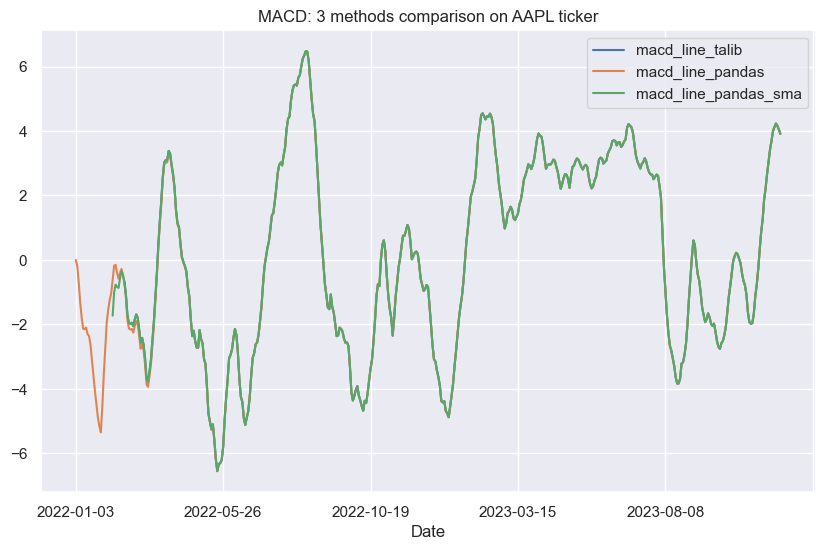

In [67]:
chosen_stock_prices[['macd_line_talib','macd_line_pandas','macd_line_pandas_sma']].plot(figsize=(10,6))
plt.title("MACD: 3 methods comparison on {} ticker".format(chosen_ticker))
plt.show()

We observe that the out-of-the-box pandas implementations slightly differes from the talib implementation while the initialization with simple moving average is more faithful.

### 3.3 Interpretations

In [68]:
def plot_technical_indicators(df, ticker='GOOG') :
    
    buy_signals = (df['macd_line_pandas_sma'] > df['signal_pandas_ema_sma']) & (df['macd_line_pandas_sma'].shift(1) <= df['signal_pandas_ema_sma'].shift(1))
    sell_signals = (df['macd_line_pandas_sma'] < df['signal_pandas_ema_sma']) & (df['macd_line_pandas_sma'].shift(1) >= df['signal_pandas_ema_sma'].shift(1))
    
    # Find centerline crossover points
    bullish_centerline_crossover = (df['macd_line_pandas_sma'] > 0) & (df['macd_line_pandas_sma'].shift(1) <= 0)
    bearish_centerline_crossover = (df['macd_line_pandas_sma'] < 0) & (df['macd_line_pandas_sma'].shift(1) >= 0)
    
    figsize=(12,15)
    fig, (ax0,ax1, ax2) = plt.subplots(nrows=3, sharex=False, subplot_kw=dict(frameon=True),figsize=figsize)
    
    ################### FAST EMA, SLOW EMA AND CLOSE PRICE
    df[['fast_ema','slow_ema']].plot(ax=ax0,style='--')
    close_price_line = df[['Adj Close']].plot(ax=ax0)
    
    ax0.set_title("Fast and Slow EMA plotted against Close prices on {} stock".format(ticker))
    ax0.set_ylabel("Close Prices ($)")
    
    
    ################### MACD indicators and buy and sell signals
    df['macd_line_pandas_sma'].plot(ax=ax1,label='macd',c='orange')
    df['signal_pandas_ema_sma'].plot(ax=ax1,style='--',label='macd signal line',c='blue')
    ax1.bar(df.index,df['macd_hist_sma'],label='macd histogram')
    ax1.axhline(y=0, color='black', linestyle='--')
    
    # Adding big circle points for buy and sell signals
    for index in df[buy_signals].index:
        ax1.scatter(index, df.at[index, 'macd_line_pandas_sma'], color='green', s=50, zorder=5)
    
    for index in df[sell_signals].index:
        ax1.scatter(index, df.at[index, 'macd_line_pandas_sma'], color='red', s=50, zorder=5)
    
    # Manually defining legend
    macd_line_legend = plt.Line2D([0], [0], color='orange', label='MACD line', markersize=10)
    macd_signal_legend = plt.Line2D([0], [0], color='blue', label='MACD Signal line', markersize=10)
    bar_legend = plt.Line2D([0], [0], marker='s', color='w', label='MACD Histogram', markersize=10)
    buy_legend = plt.Line2D([0], [0], marker='o', color='w', label='Buy Signal', markersize=10, markerfacecolor='green')
    sell_legend = plt.Line2D([0], [0], marker='o', color='w', label='Sell Signal', markersize=10, markerfacecolor='red')

    ax1.legend(handles=[macd_line_legend, macd_signal_legend, bar_legend ,buy_legend, sell_legend])
    
    ax1.set_title("MACD Indicators with Buy and Sell Signals on {} stock".format(ticker))
    
    ################### MACD indicators and bearish and bullish crossovers
    
    df['macd_line_pandas_sma'].plot(ax=ax2,label='macd',c='orange')
    df['signal_pandas_ema_sma'].plot(ax=ax2,style='--',label='macd signal line',c='blue')
    ax2.bar(df.index,df['macd_hist_sma'],label='macd histogram')
    ax2.axhline(y=0, color='black', linestyle='--')
    
    # Adding diagonal lines for centerline crossovers
    window = 5
    shift = 0
    for index in df[bullish_centerline_crossover].index:
        idx = df.index.get_loc(index)
        if idx > 0:
            prev_date = df.index[idx - window]
            curr_date = df.index[idx + window] if idx+window < df.shape[0] else df.index[df.shape[-1]]
            prev_value = df.at[prev_date, 'macd_line_pandas_sma'] + shift
            curr_value = df.at[curr_date, 'macd_line_pandas_sma'] + shift
            ax2.plot([prev_date, curr_date], [prev_value, curr_value], color='black', lw=2)

    for index in df[bearish_centerline_crossover].index:
        idx = df.index.get_loc(index)
        if idx > 0:
            prev_date = df.index[idx - window]
            curr_date = df.index[idx + window] if idx+window < df.shape[0] else df.index[df.shape[-1]]
            prev_value = df.at[prev_date, 'macd_line_pandas_sma'] + shift
            curr_value = df.at[curr_date, 'macd_line_pandas_sma'] + shift
            ax2.plot([prev_date, curr_date], [prev_value, curr_value], color='gray', lw=2)
    
    #Bullish and bearish
    bullish_centerline_legend = plt.Line2D([0], [0], lw=2, color='black', label='Bullish Centerline Crossover', markersize=10)
    bearish_centerline_legend = plt.Line2D([0], [0], lw=2, color='gray', label='Bearish Centerline Crossover', markersize=10)
    
    ax2.legend(handles=[macd_line_legend, macd_signal_legend, bar_legend ,bullish_centerline_legend, bearish_centerline_legend])
    
    
    ax2.set_title("MACD Indicators with Bullish and Bearish crossovers on {} stock".format(ticker))
    plt.show()

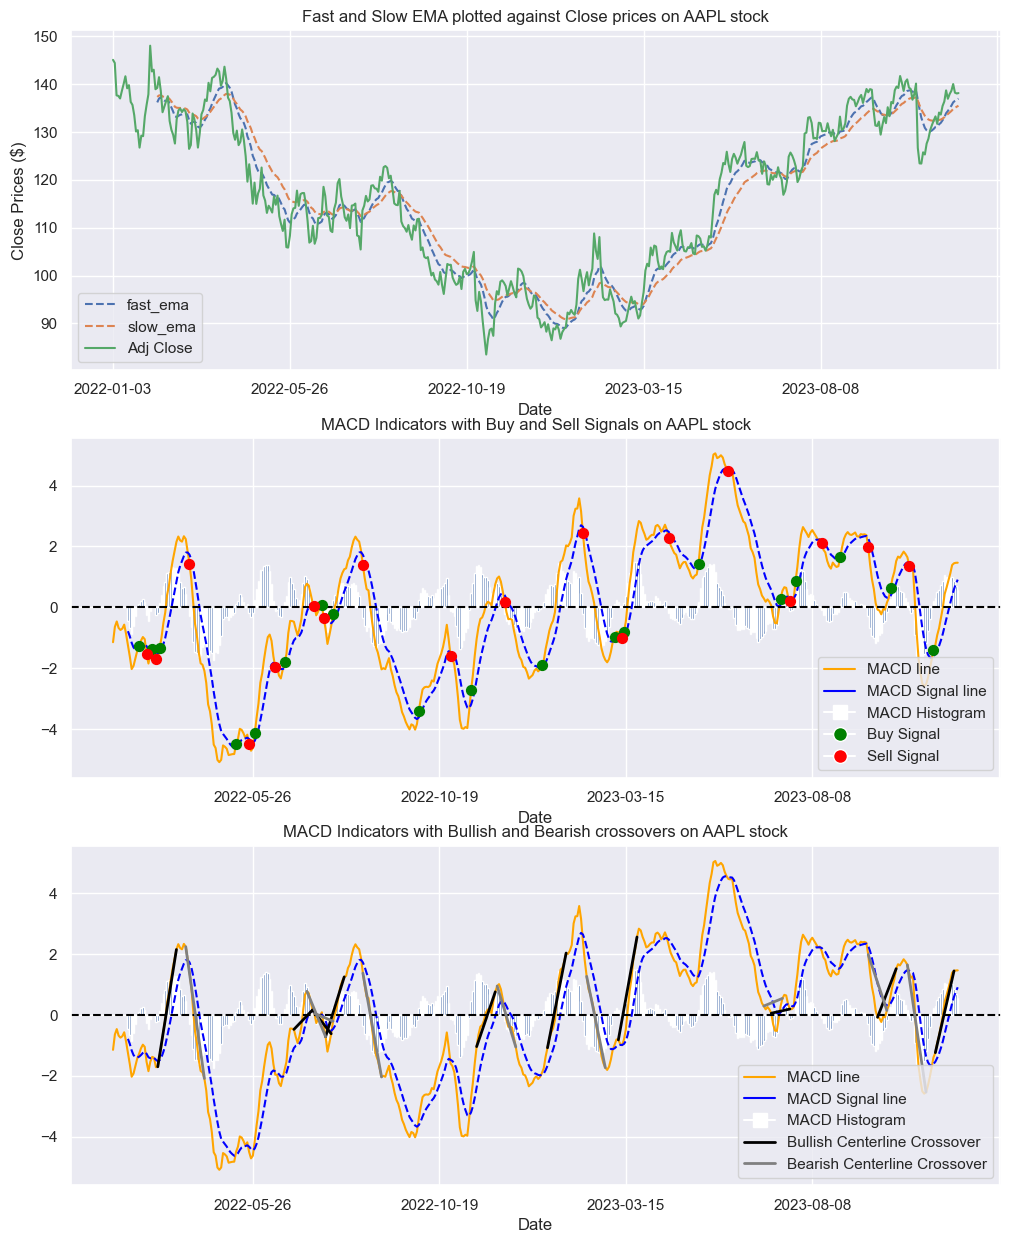

In [69]:
plot_technical_indicators(google_stock, ticker=chosen_ticker)

**MACD, Fast and Slow EMA**

The MACD line is the difference between two moving averages (a slow one and a fast one). It helps spot when a trend is changing. 

By looking at how the MACD line compares to its signal line, it can help figuring out how strong the trend is and whether it's about to reverse.

**Signal Line Crossovers**:
- If the MACD line goes above the signal line, it's a sign you might want to buy. This is called a bullish crossover.
- If the MACD line drops below the signal line, it's a hint you might want to sell. This is known as a bearish crossover.
- These crossovers show that the price of the asset is starting to move faster, either up or down.
- However, sometimes these signals can be misleading, especially when the price of the asset is changing rapidly and unpredictably. (highly volatile)

**Centerline Crossovers**:
- When the MACD line crosses the zero line, it means the trend's direction is changing.
- If the MACD line moves above zero, it suggests the trend is becoming positive, or bullish.
- If the MACD line goes below zero, it suggests the trend is turning negative, or bearish.
- Crossing the zero line is another way to confirm that the trend direction is changing.

**Caveat** : It may be useful to use other indicators to back these signals, or wait some time to confirm momentum directions before taking any trading decision.

## 4. Trading strategies and BackTesting

Can we use MACD technical indicators to devise a trading strategy for an asset porfolio ?

### 4.1 Data Preparation

In [70]:
chosen_stock_prices.tail()

,Open,High,Low,Close,Adj Close,Volume,ticker,macd_line_talib,macd_signal_talib,macd_hist_talib,macd_line_pandas,macdsignal_pandas,macdhist_pandas,macd_line_pandas_sma,signal_pandas_ema_sma,macd_hist_sma,fast_ema,slow_ema
Date,,,,,,,,,,,,,,,,,,
2023-11-21,191.410004,191.520004,189.740005,190.639999,190.639999,38134500,AAPL,4.124882,2.887255,1.237627,4.124882,2.887255,1.237627,4.124882,2.887255,1.237627,186.128381,182.003498
2023-11-22,191.490005,192.929993,190.830002,191.309998,191.309998,39617700,AAPL,4.232684,3.156341,1.076343,4.232684,3.156341,1.076343,4.232684,3.156341,1.076343,186.925553,182.692869
2023-11-24,190.869995,190.899994,189.250000,189.970001,189.970001,24048300,AAPL,4.162014,3.357475,0.804538,4.162014,3.357475,0.804538,4.162014,3.357475,0.804538,187.393929,183.231916
2023-11-27,189.919998,190.669998,188.899994,189.789993,189.789993,40552600,AAPL,4.044855,3.494951,0.549904,4.044855,3.494951,0.549904,4.044855,3.494951,0.549904,187.762554,183.717699
2023-11-28,189.779999,191.080002,189.399994,189.865005,189.865005,25173433,AAPL,3.912953,3.578552,0.334402,3.912953,3.578552,0.334402,3.912953,3.578552,0.334402,188.086008,184.173055


In [93]:
def obtain_technical_indicators(df) :

    #Apply MACD
    df = macd_custom_pandas_implementation(df)

    # Find crossover points
    buy_signals = (df['macd_line_pandas_sma'] > df['signal_pandas_ema_sma']) & (df['macd_line_pandas_sma'].shift(1) <= df['signal_pandas_ema_sma'].shift(1))
    sell_signals = (df['macd_line_pandas_sma'] < df['signal_pandas_ema_sma']) & (df['macd_line_pandas_sma'].shift(1) >= df['signal_pandas_ema_sma'].shift(1))
    
    # Find centerline crossover points
    bullish_centerline_crossover = (df['macd_line_pandas_sma'] > 0) & (df['macd_line_pandas_sma'].shift(1) <= 0)
    bearish_centerline_crossover = (df['macd_line_pandas_sma'] < 0) & (df['macd_line_pandas_sma'].shift(1) >= 0)
    
    
    df['buy_signals'] = buy_signals.values
    df['sell_signals'] = sell_signals.values
    df['bullish_centerline_crossover'] = bullish_centerline_crossover.values
    df['bearish_centerline_crossover'] = bearish_centerline_crossover.values

    return df


stock_prices_with_technical_indicators = None

for ticker in tickers :
    if(stock_prices_with_technical_indicators is None) :
        stock_prices_with_technical_indicators = obtain_technical_indicators(stocks_prices.loc[stocks_prices['ticker'] == ticker])
    else :
        stock_prices_with_technical_indicators = pd.concat([stock_prices_with_technical_indicators, obtain_technical_indicators(stocks_prices.loc[stocks_prices['ticker'] == ticker])])


USEFUL_COLUMNS = [
    'ticker',
    'Open',
    'High',
    'Low',
    'Adj Close',
    'Volume',
    'macd_line_pandas_sma',
    'signal_pandas_ema_sma',
    'macd_hist_sma',
    'fast_ema',
    'slow_ema',
    'buy_signals',
    'sell_signals',
    'bullish_centerline_crossover',
    'bearish_centerline_crossover'
]

trading_dataset = stock_prices_with_technical_indicators[USEFUL_COLUMNS].copy()
trading_dataset = trading_dataset.rename(columns={
    'Adj Close' : 'Close',
    'macd_line_pandas_sma' : 'MACD_line',
    'signal_pandas_ema_sma' : 'MACD_signal',
    'macd_hist_sma' : 'MACD_hist',
    'fast_ema' : 'Short_EMA',
    'slow_ema' : 'Long_EMA',
    'buy_signals' : 'MACD_signal_upward_cross',
    'sell_signals' : 'MACD_signal_downward_cross',
})

trading_dataset.sort_index(inplace=True)

In [94]:
trading_dataset.tail()

,ticker,Open,High,Low,Close,Volume,MACD_line,MACD_signal,MACD_hist,Short_EMA,Long_EMA,MACD_signal_upward_cross,MACD_signal_downward_cross,bullish_centerline_crossover,bearish_centerline_crossover
Date,,,,,,,,,,,,,,,
2023-11-28,AAPL,189.779999,191.080002,189.399994,189.865005,25173433,3.912953,3.578552,0.334402,188.086008,184.173055,False,False,False,False
2023-11-28,META,333.399994,337.561401,333.399994,336.959991,8565713,7.354831,6.864804,0.490027,333.405539,326.050708,False,False,False,False
2023-11-28,AMZN,146.979996,147.599899,145.529999,146.854996,29640327,3.810141,3.622075,0.188066,144.606329,140.796188,False,False,False,False
2023-11-28,GOOG,137.630005,138.320007,137.039993,138.132202,10640132,1.464447,0.908555,0.555891,136.957341,135.492894,False,False,False,False
2023-11-28,MSFT,378.350006,383.000000,378.160004,381.250000,13992495,11.344280,10.963100,0.381180,372.397152,361.052872,False,False,False,False


### 4.2 Simple Portfolio Trading Strategy

In [124]:
trading_dataset.head(10)

,ticker,Open,High,Low,Close,Volume,MACD_line,MACD_signal,MACD_hist,Short_EMA,Long_EMA,MACD_signal_upward_cross,MACD_signal_downward_cross,bullish_centerline_crossover,bearish_centerline_crossover
Date,,,,,,,,,,,,,,,
2022-01-03,GOOG,144.475494,145.550003,143.502502,145.074493,25214000,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2022-01-03,AMZN,167.550003,170.703506,166.160507,170.404495,63520000,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2022-01-03,MSFT,335.350006,338.000000,329.779999,328.727631,28865100,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2022-01-03,AAPL,177.830002,182.880005,177.710007,179.953888,104487900,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2022-01-03,META,338.299988,341.079987,337.190002,338.540009,14537900,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2022-01-04,GOOG,145.550507,146.610001,143.816147,144.416504,22928000,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2022-01-04,MSFT,334.829987,335.200012,326.119995,323.090912,32674300,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2022-01-04,AMZN,170.438004,171.399994,166.349503,167.522003,70726000,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2022-01-04,AAPL,182.630005,182.940002,179.119995,177.669983,99310400,NaN,NaN,NaN,NaN,NaN,False,False,False,False


In [184]:
def simple_macd_strategy(df, tickers, portfolio_initial_value = 100000, amount_spending_allocation = 10000) :

    # Initialize portfolio
    cash_balance = portfolio_initial_value
    holdings = {ticker: 0 for ticker in tickers}
    daily_portfolio_values = []
    allowed_amount_per_trade = amount_spending_allocation

    

    #Implement the strategy
    for idx in df.index.unique():
        current_holding_value = 0
        for ticker in tickers:
            # Check for buy/sell/hold signal.

            
            #EMA at time t is computed using data from t-1, t-2, ... so we are safe in using MACD signal at time t
            #buy_condition : if MACD crosses signal -> trend is changing upward -> we buy
            buy_condition = (df.loc[(df.index == idx) & (df.ticker == ticker), 'MACD_signal_upward_cross'].values[0] == True) or (df.loc[(df.index == idx) & (df.ticker == ticker), 'bullish_centerline_crossover'].values[0] == True)
            sell_condition = (df.loc[(df.index == idx) & (df.ticker == ticker), 'MACD_signal_downward_cross'].values[0] == True) or (df.loc[(df.index == idx) & (df.ticker == ticker), 'bearish_centerline_crossover'].values[0] == True)

            
            #We assume we make the trade orders before market opens
            #and that we will be buying at market value
            asset_price = df.loc[(df.index == idx) & (df.ticker == ticker), 'Open'].values[0]
            ticker_holdings_value = holdings[ticker] * asset_price
            current_holding_value += ticker_holdings_value
            
            if buy_condition:
                # Execute buy if sufficient cash is available
                if(cash_balance > 0) :
                    maximum_shares_to_buy = min(allowed_amount_per_trade, cash_balance) //  asset_price
                    spent_amount = maximum_shares_to_buy * asset_price
                    
                    # Update cash_balance and holdings
                    #if(spent_amount <= cash_balance) :
                    cash_balance -= spent_amount
                    holdings[ticker] += maximum_shares_to_buy
            
            elif sell_condition:
                # Execute sell if holdings are available

                if(holdings[ticker] > 0) : #If we have holdings available to sell
                    maximum_shares_to_sell = min(allowed_amount_per_trade, ticker_holdings_value) //  asset_price
                    earned_amount = maximum_shares_to_sell * asset_price
                
                    # Update cash_balance and holdings
                    cash_balance += earned_amount
                    holdings[ticker] -= maximum_shares_to_sell
            else : 
                #if neither buy nor sell, we hold
                pass


        #Update portfolio value for the day
        daily_portfolio_value = cash_balance + current_holding_value
        daily_portfolio_values.append([idx, daily_portfolio_value, cash_balance, current_holding_value]+[holdings[t] for t in tickers])

    return daily_portfolio_values

In [185]:
#print(trading_dataset.shape)

portfolio_values = simple_macd_strategy(trading_dataset, tickers)

In [186]:
portfolio_over_time = pd.DataFrame(portfolio_values, columns=['date', 'portfolio_value', 'cash_balance', 'holdings_value']+['{}_holdings'.format(t) for t in tickers])
portfolio_over_time

,date,portfolio_value,cash_balance,holdings_value,GOOG_holdings,AMZN_holdings,META_holdings,AAPL_holdings,MSFT_holdings
0,2022-01-03,100000.000000,100000.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,2022-01-04,100000.000000,100000.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,2022-01-05,100000.000000,100000.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,2022-01-06,100000.000000,100000.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,2022-01-07,100000.000000,100000.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
474,2023-11-21,152695.280343,3790.829989,148904.450354,149.0,150.0,157.0,137.0,73.0
475,2023-11-22,153286.331205,3790.829989,149495.501216,149.0,150.0,157.0,137.0,73.0
476,2023-11-24,153681.977647,3790.829989,149891.147658,149.0,150.0,157.0,137.0,73.0
477,2023-11-27,152722.499436,3790.829989,148931.669447,149.0,150.0,157.0,137.0,73.0


### 5.0 Defining Performance metrics

Before diving in other strategies, let's define some **performance metrics** on which we will try to improve.

Those will include Total Returns, Annualized Returns, Maximum Drawdown, Sharpe Ratio, Sortino Ratio and Beta to the Market.